# Association Rules
## Example with the [__Online Retail__](https://archive.ics.uci.edu/ml/datasets/online+retail) dataset, from UCI

Code provided in this [link](http://pbpython.com/market-basket-analysis.html)

In [1]:
try:
    from mlxtend.frequent_patterns import apriori, association_rules
except ImportError:
    # !conda install -c conda-forge -n base mlxtend --yes # install mlxtend if not already installed
    !pip install mlxtend
    from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
import pandas as pd
import numpy as np

Upload the file `'Online-Retail-France.xlsx'`. It is a MS Excel file, you can read it with the Pandas' function `read_excel`.

Inspect its content. It is a transactional database where the role of transaction identifier is played by the column `InvoiceNo` and the items are in the column `Description`.

In [3]:
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
url = 'Online-Retail-France.xlsx'
df0 = pd.read_excel(url
                    # , dtype = {  'InvoiceNo': 'str'
                    #               , 'StockCode':'str'
                    #               , 'Description':'str'
                    #               , 'CustomerID':'Int64'
                    #               }
                    )
print("There are {} rows and {} columns".format(df0.shape[0], df0.shape[1]))

There are 8557 rows and 7 columns


In [4]:
df0.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0


In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8557 entries, 0 to 8556
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    8556 non-null   object 
 1   StockCode    8557 non-null   object 
 2   Description  8557 non-null   object 
 3   Quantity     8557 non-null   int64  
 4   InvoiceDate  8557 non-null   object 
 5   UnitPrice    8557 non-null   float64
 6   CustomerID   8491 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 468.1+ KB


In [6]:
print("The number of unique Description values in the input file is {}".format(len(df0['Description'].unique())))

The number of unique Description values in the input file is 1565


In [7]:
df1 = df0
df1['Description'] = df0['Description'].str.strip()

In [8]:
print("After cleaning, the number of unique Description values in the input file is {}".format(len(df1['Description'].unique())))

After cleaning, the number of unique Description values in the input file is 1564


Some rows may not have an `InvoiceNo` and must be removed, because they cannot be used.

Check if there are such that rows and in case remove them. 

In [9]:
print("Rows with missing InvoiceNo before removing")
df1[df1['InvoiceNo'].isna()]

Rows with missing InvoiceNo before removing


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
15,NaN,21913,VINTAGE SEASIDE JIGSAW PUZZLES,12,2010-12-01 08:45:00,3.75,12583.0


In [10]:
df2 = df1.dropna(axis=0, subset=['InvoiceNo'])

In [11]:
print("Rows with missing InvoiceNo after removing")
df2[df2['InvoiceNo'].isna()]

Rows with missing InvoiceNo after removing


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID


Some InvoiceNo start with a `C`. They are "credit transactions" and must be removed.

Check the number of rows containing `C` in `InvoiceNo` and remove them. 
At the moment the column `InvoiceNo` is a generic object, in order to be 
able to use string functions, such as `contains`, it must be transformed into `str` with `astype`.

In [12]:
print("There are {} rows containing 'C' in 'InvoiceNo'"\
      .format(sum(df2['InvoiceNo'].str.contains('C'))))
      # .format(sum(df2['InvoiceNo'].astype('str').str.contains('C'))))

There are 149 rows containing 'C' in 'InvoiceNo'


In [13]:
df3 = df2[~df2['InvoiceNo'].str.contains('C')]

In [14]:
print("After removal, there are {} rows containing 'C' in 'InvoiceNo'"\
      .format(sum(df3['InvoiceNo'].str.contains('C'))))

After removal, there are 0 rows containing 'C' in 'InvoiceNo'


Several transactions include the item `'POSTAGE'`, 
which represents the mailing expenses. 
In this analysis we are not interested in it, therefore the rows 
with `'POSTAGE'` will be removed.

In [15]:
container = 'Description'
target = 'POSTAGE'
print("There are {} rows containing {} in {}"\
      .format(sum(df3[container].str.contains(target)), target, container))

There are 300 rows containing POSTAGE in Description


In [16]:
df = df3[~df3[container].str.contains(target)]
print("After cleaning there are {} rows containing {} in {}"\
      .format(sum(df[container].str.contains(target)), target, container))

After cleaning there are 0 rows containing POSTAGE in Description


In [17]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
count,8107,8107,8107,8107.000000,8107,8107.00000,8041.000000
unique,387,1541,1562,NaN,388,NaN,NaN
top,570672,23084,RABBIT NIGHT LIGHT,NaN,2011-10-11 14:52:00,NaN,NaN
freq,259,74,74,NaN,259,NaN,NaN
mean,NaN,NaN,NaN,13.724806,NaN,3.83965,12679.910583
std,NaN,NaN,NaN,21.354558,NaN,66.58728,281.252392
min,NaN,NaN,NaN,1.000000,NaN,0.00000,12413.000000
25%,NaN,NaN,NaN,6.000000,NaN,1.00000,12571.000000
50%,NaN,NaN,NaN,10.000000,NaN,1.65000,12674.000000
75%,NaN,NaN,NaN,12.000000,NaN,2.95000,12689.000000


After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, we are only looking at sales for France. However, in additional code below, we will compare these results to sales from Germany. Further country comparisons would be interesting to investigate.

Actions:
1. group by `['InvoiceNo', 'Description']` computing a sum on `['Quantity']`
1. use the `unstack` function to move the items from rows to columns
1. reset the index
1. fill the missing with zero (`fillna(0)`)
1. store the result in the new dataframe `basket` and inspect it

In [18]:
basket = (df
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo')) # in this way, InvoiceNo is not a column anymore
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
basket.describe()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,...,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,0.868217,0.310078,0.005168,0.062016,0.509044,0.385013,0.400517,0.062016,0.281654,0.186047,...,0.193798,0.023256,0.010336,0.002584,0.082687,0.279070,0.012920,0.186047,0.031008,0.062016
std,5.109242,2.474110,0.101666,0.861544,5.445138,2.978173,3.454711,1.219989,2.006660,1.484466,...,2.195417,0.340644,0.203331,0.050833,1.626651,2.348994,0.254164,1.922464,0.609994,0.861544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,48.000000,20.000000,2.000000,12.000000,96.000000,24.000000,48.000000,24.000000,24.000000,12.000000,...,25.000000,6.000000,4.000000,1.000000,32.000000,36.000000,5.000000,24.000000,12.000000,12.000000


There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0. 

You can define a function `encode_units` which takes a number and returns 0 if the number is 0 or less, 1 if the number is 1 or more. The function can be applied to `basket` with the Pandas' function `map`, the result is stored in the variable `basket_sets`.

An even easier alternative is:
- use `.clip(0)` to convert negatives to 0
- use `astype` to convert into boolean. Python interprets `0` as `False` and _non-zero integers_ as `True`

Inspect the structure and the correctness of the result

This step will complete the one hot encoding of the data.

In [ ]:
basket_sets = basket.clip(0).astype('bool')
basket_sets.describe()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
count,387,387,387,387,387,387,387,387,387,387,...,387,387,387,387,387,387,387,387,387,387
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,375,381,386,385,381,380,380,386,378,381,...,384,385,386,386,386,380,386,383,386,385


Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that we can get enough useful examples):

- generate the `frequent_itemsets` with `apriori`, setting `min_support=0.07` and `use_colnames=True`
- generate the `rules` with `association_rules` using `metric="lift"` and `min_threshold=1`
- show the rules

In [21]:
step = 0.01
min_support = 1
min_rules = 20
metric = 'lift'
min_threshold = 1
while True:
    frequent_itemsets = apriori(basket_sets, min_support=min_support, use_colnames=True)
    if frequent_itemsets.shape[0]>0:
        rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    if frequent_itemsets.shape[0] >0 and rules.shape[0]>=min_rules:
        break
    else:
        min_support -= step

In [22]:
print("'min_support'={:4.2f}, 'metric'={}, 'min_threshold'={}, number of frequent itemsets={}, number of rules={}"\
      .format(min_support, metric, min_threshold, frequent_itemsets.shape[0], rules.shape[0]))

'min_support'=0.08, 'metric'=lift, 'min_threshold'=1, number of frequent itemsets=41, number of rules=20


In [23]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095607,0.098191,0.080103,0.837838,8.532717,1.0,0.070716,5.561154,0.976129,0.704545,0.820181,0.826814
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.098191,0.095607,0.080103,0.815789,8.532717,1.0,0.070716,4.909561,0.978926,0.704545,0.796316,0.826814
2,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.170543,0.139535,0.090439,0.530303,3.800505,1.0,0.066643,1.831958,0.888385,0.411765,0.454136,0.589226
3,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.139535,0.170543,0.090439,0.648148,3.800505,1.0,0.066643,2.357405,0.856371,0.411765,0.575805,0.589226
4,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.173127,0.170543,0.103359,0.597015,3.500678,1.0,0.073834,2.058283,0.863906,0.430108,0.514158,0.601538
5,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.170543,0.173127,0.103359,0.606061,3.500678,1.0,0.073834,2.098986,0.861215,0.430108,0.523580,0.601538
6,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.173127,0.139535,0.105943,0.611940,4.385572,1.0,0.081786,2.217352,0.933613,0.512500,0.549012,0.685600
7,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.139535,0.173127,0.105943,0.759259,4.385572,1.0,0.081786,3.434705,0.897165,0.512500,0.708854,0.685600
8,(SET/20 RED RETROSPOT PAPER NAPKINS),(SET/6 RED SPOTTY PAPER CUPS),0.134367,0.139535,0.103359,0.769231,5.512821,1.0,0.084610,3.728682,0.945672,0.606061,0.731809,0.754986
9,(SET/6 RED SPOTTY PAPER CUPS),(SET/20 RED RETROSPOT PAPER NAPKINS),0.139535,0.134367,0.103359,0.740741,5.512821,1.0,0.084610,3.338870,0.951351,0.606061,0.700498,0.754986


In order to plot the rules, it is better to sort them according to some metrics.
We will sort on descending lift, support and confidence and scatter plot `'lift'` in x axis, `'support'` in y axis and `'confdence'` as the dot size.

In [24]:
sorted_rules=rules.sort_values(by=['lift','confidence'],ascending=False).reset_index(drop=True)
sorted_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095607,0.098191,0.080103,0.837838,8.532717,1.0,0.070716,5.561154,0.976129,0.704545,0.820181,0.826814
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.098191,0.095607,0.080103,0.815789,8.532717,1.0,0.070716,4.909561,0.978926,0.704545,0.796316,0.826814
2,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER PLATES),0.103359,0.129199,0.100775,0.975000,7.546500,1.0,0.087421,34.832041,0.967487,0.764706,0.971291,0.877500
3,(SET/6 RED SPOTTY PAPER PLATES),"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",0.129199,0.103359,0.100775,0.780000,7.546500,1.0,0.087421,4.075640,0.996196,0.764706,0.754640,0.877500
4,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.103359,0.139535,0.100775,0.975000,6.987500,1.0,0.086353,34.418605,0.955664,0.709091,0.970946,0.848611


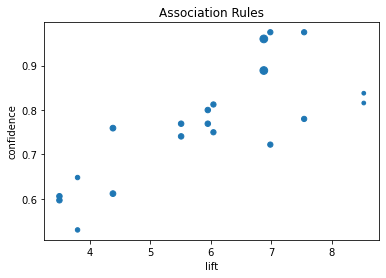

In [25]:
sorted_rules.plot.scatter(x='lift',y='confidence',s=3**(sorted_rules['support']*30),title='Association Rules');

You find below a three dimensional plot, where the dot size is proportional to the lift, obtained using `plot.scatter`.

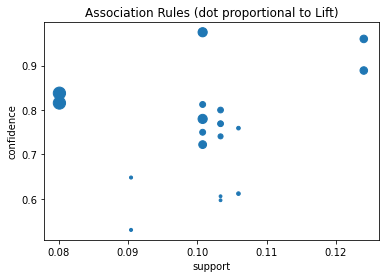

In [26]:
s = [1.8**n for n in rules.lift]
rules.plot.scatter(x='support', 
                   y='confidence', 
                   title='Association Rules (dot proportional to Lift)', 
                   s=s);